In [1]:
import numpy
import numpy as np
from epg import cpmg_epg
from matplotlib import pyplot as plt
import timeit

In [2]:
%matplotlib inline

In [3]:
def  epg_grad(FpFmZ, noadd=0):
#     if noadd == 0:
#         FpFmZ = np.concatenate((FpFmZ,np.zeros((3,1))), axis=1)
        
    FpFmZ[0,:] = np.roll(FpFmZ[0,:], 1)
    FpFmZ[1,:] = np.roll(FpFmZ[1,:],-1)
    FpFmZ[1,-1] = 0
    FpFmZ[0,0] = np.conjugate(FpFmZ[1,0])
    
    return(FpFmZ)
    
  
def epg_grelax( FpFmZ, T1, T2, T, kg = 0, D = 0, Gon = 1, noadd = 0):
    
    E1 = np.exp(-T/T1)
    E2 = np.exp(-T/T2)
    
    EE = np.diag([E2, E2, E1])
    RR = 1.0-E1
    
    FpFmZ = np.dot( EE, FpFmZ)
    
    FpFmZ[2,0] = FpFmZ[2,0]+RR
    
#     print(EE)
#     print('RR=',RR)
#     print('FpFmZ=\n',FpFmZ[:,:4].real)
    
    ##Assume Gradient is on and kg >= 0
    
    FpFmZ = epg_grad(FpFmZ, noadd)
    
    
    return(FpFmZ)


def  epg_rf( FpFmZ, alpha, phi ):
    
    RR = np.zeros((3,3), dtype = np.complex128)
    
    RR[0,0] = np.cos(alpha/2.)**2
    RR[0,1] = np.exp(2.0*1j*phi)*(np.sin(alpha/2.0))**2
    RR[0,2] = -1j*np.exp(1j*phi)*np.sin(alpha)
    
    RR[1,0] = np.exp(-2j*phi)*(np.sin(alpha/2.0))**2
    RR[1,1] = (np.cos(alpha/2.0))**2
    RR[1,2] = 1j*np.exp(-1j*phi)*np.sin(alpha)
    
    RR[2,0] = (-1j/2.0)*np.exp(-1j*phi)*np.sin(alpha)
    RR[2,1] = ( 1j/2.0)*np.exp( 1j*phi)*np.sin(alpha)
    RR[2,2] = np.cos(alpha)
    
    FpFmZ = np.dot(RR, FpFmZ)
    
    return( FpFmZ, RR)


def  rf_pulse( alpha, phi ):
    
    RR = np.zeros((3,3), dtype = np.complex128)
    
    RR[0,0] = np.cos(alpha/2.)**2
    RR[0,1] = np.exp(2.0*1j*phi)*(np.sin(alpha/2.0))**2
    RR[0,2] = -1j*np.exp(1j*phi)*np.sin(alpha)
    
    RR[1,0] = np.exp(-2j*phi)*(np.sin(alpha/2.0))**2
    RR[1,1] = (np.cos(alpha/2.0))**2
    RR[1,2] = 1j*np.exp(-1j*phi)*np.sin(alpha)
    
    RR[2,0] = (-1j/2.0)*np.exp(-1j*phi)*np.sin(alpha)
    RR[2,1] = ( 1j/2.0)*np.exp( 1j*phi)*np.sin(alpha)
    RR[2,2] = np.cos(alpha)

    
    return(RR)


def cpmg_epg_py( Nechos=17, rf_180=120.0, T1=3000.0, T2=50.0, Techo=10.0 ):
	

    P = np.zeros((3,2*Nechos),dtype=np.complex128)
    
    P[0,0] = 0.0  # Fp
    P[1,0] = 0.0  # Fm
    P[2,0] = 1.0  # Z
    
    signal = np.zeros(Nechos)
    
    rf_pulse90_rad = np.pi*rf_180/360.
    #rf_pulse90_rad = np.pi/2.0
    rf_pulse_rad = np.pi*rf_180/180.
    
    RR90  = rf_pulse(rf_pulse90_rad, np.pi/2.0)
    RR180 = rf_pulse(rf_pulse_rad,   0.0)
    
    P = np.dot( RR90, P )
    #signal[0] = P[0,0].real
    
    for echo in range(Nechos):
        P = epg_grelax( P, T1, T2, Techo/2.0)
        P = np.dot(RR180,P)
        P = epg_grelax( P, T1, T2, Techo/2.0)
        
        signal[echo] = (P[0,0].real)
        
    return(signal)


def cpmg_epg_py2( Nechos=17, rf_180=120.0, T1=3000.0, T2=50.0, Techo=10.0 ):
	

    P = np.zeros((3,2*Nechos),dtype=np.complex128)
    
    P[0,0] = 0.0  # Fp
    P[1,0] = 0.0  # Fm
    P[2,0] = 1.0  # Z
    
    signal = np.zeros(Nechos)
    
    #rf_pulse90_rad = np.pi*rf_180/360.
    rf_pulse90_rad = np.pi/2.0
    rf_pulse_rad = np.pi*rf_180/180.
    
    RR90  = rf_pulse(rf_pulse90_rad, np.pi/2.0)
    RR180 = rf_pulse(rf_pulse_rad,   0.0)
    
    P = np.dot( RR90, P )
    #signal[0] = P[0,0].real
    
    for echo in range(Nechos):
        P = epg_grelax( P, T1, T2, Techo/2.0)
        P = np.dot(RR180,P)
        P = epg_grelax( P, T1, T2, Techo/2.0)
        
        signal[echo] = (P[0,0].real)
        
    return(signal)

In [4]:
Nechos=17
T1=3000.0
T2=100.0
T = 10.0
P180 = 120.0

signal = numpy.zeros(Nechos)
#signal = [0.0]*Nechos
xxx = numpy.arange( T, T*(Nechos+1), T )

In [5]:
cpmg_epg(signal, P180, T1, T2, T )
signal_py = cpmg_epg_py( Nechos=17, rf_180=P180, T1=T1, T2=T2, Techo=T )

In [6]:
ttt_py = timeit.timeit('cpmg_epg_py( Nechos=17, rf_180=130.0, T1=3000.0, T2=100.0, Techo=10.0 )', setup="from __main__ import cpmg_epg_py", number=10000)

In [7]:
ttt_c = timeit.timeit('cpmg_epg( signal,  P180, T1, T2, T )', setup="from __main__ import cpmg_epg, signal, P180, T1, T2, T", number=10000)

In [8]:
print( ttt_py, ttt_c,  ttt_py/ttt_c )

13.761113662715529 0.22544037983839083 61.04103298876767


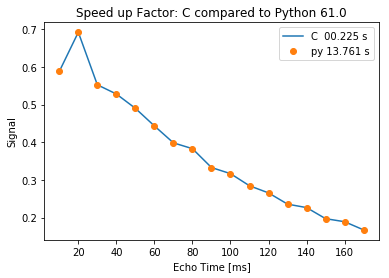

In [9]:
plt.plot(xxx,signal, label='C  {:>06.3f} s'.format(ttt_c))
plt.plot(xxx,signal_py, 'o', label='py {:>06.3f} s'.format(ttt_py))
plt.xlabel("Echo Time [ms]" )
plt.ylabel("Signal" )
plt.title("Speed up Factor: C compared to Python {:.1f}".format(ttt_py/ttt_c))
plt.legend();

In [10]:
signal_py_180 = cpmg_epg_py2( Nechos=17, rf_180=180.0, T1=T1, T2=T2, Techo=T )
signal_py_160 = cpmg_epg_py2( Nechos=17, rf_180=160.0, T1=T1, T2=T2, Techo=T )
signal_py_140 = cpmg_epg_py2( Nechos=17, rf_180=140.0, T1=T1, T2=T2, Techo=T )
signal_py_120 = cpmg_epg_py2( Nechos=17, rf_180=120.0, T1=T1, T2=T2, Techo=T )


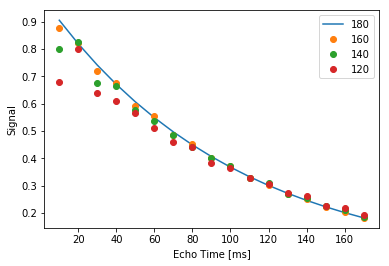

In [11]:
plt.plot(xxx,signal_py_180, label='180')
plt.plot(xxx,signal_py_160, 'o', label='160')
plt.plot(xxx,signal_py_140, 'o', label='140')
plt.plot(xxx,signal_py_120, 'o', label='120')
plt.xlabel("Echo Time [ms]" )
plt.ylabel("Signal" )
plt.legend();

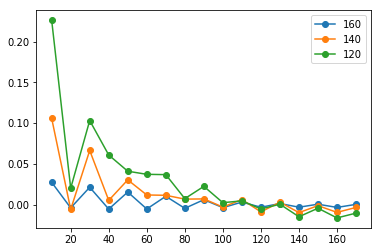

In [12]:
plt.plot(xxx,signal_py_180-signal_py_160, 'o-', label='160')
plt.plot(xxx,signal_py_180-signal_py_140, 'o-', label='140')
plt.plot(xxx,signal_py_180-signal_py_120, 'o-', label='120')
plt.legend();

In [13]:
signal_py_180 = cpmg_epg_py( Nechos=17, rf_180=180.0, T1=T1, T2=T2, Techo=T )
signal_py_160 = cpmg_epg_py( Nechos=17, rf_180=160.0, T1=T1, T2=T2, Techo=T )
signal_py_140 = cpmg_epg_py( Nechos=17, rf_180=140.0, T1=T1, T2=T2, Techo=T )
signal_py_120 = cpmg_epg_py( Nechos=17, rf_180=120.0, T1=T1, T2=T2, Techo=T )

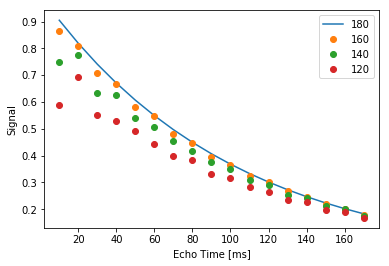

In [14]:
plt.plot(xxx,signal_py_180, label='180')
plt.plot(xxx,signal_py_160, 'o', label='160')
plt.plot(xxx,signal_py_140, 'o', label='140')
plt.plot(xxx,signal_py_120, 'o', label='120')
plt.xlabel("Echo Time [ms]" )
plt.ylabel("Signal" )
plt.legend()

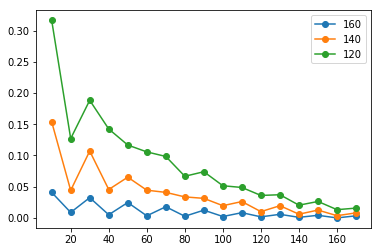

In [15]:
plt.plot(xxx,signal_py_180-signal_py_160, 'o-', label='160')
plt.plot(xxx,signal_py_180-signal_py_140, 'o-', label='140')
plt.plot(xxx,signal_py_180-signal_py_120, 'o-', label='120')
plt.legend();